# Bayesian Statistics Homework 5
Rahul Bhatia (rb3318)
Fall 2020

# Question 1

In [19]:
import pystan
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns

y_t = pd.Series({
    1: 64,
    2: 13,
    3: 33,
    4: 18,
    5: 30,
    6: 20})
data = y_t.reset_index().rename(columns={"index": "t", 0: 'y_t'})

In [600]:
bivalve_code = """
data {
    int<lower=0> y_t[6];
}

parameters {
    real alpha;
    real beta;
}

transformed parameters {
    vector[6] lambda_t;
    for (t in 1:6)
        lambda_t[t] = exp(alpha + beta * t);
}

model {
    alpha ~ normal(0, 10);
    beta ~ normal(0, 10);
    for (t in 1:6)
        y_t[t] ~ poisson(lambda_t[t]);
}

generated quantities {
    real lambda_2016 = exp(alpha + beta * 7);
    int<lower=0> y_2016_tilde = poisson_rng(lambda_2016);
}
"""
sm = pystan.StanModel(model_code=bivalve_code)
fit = sm.sampling(data=data, iter=1000, chains=4)
posterior_df = fit.to_dataframe()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f14e827eba0fdcba6db4cd057b7b96db NOW.


## Part (A) Provide Summaries for $\alpha$ and $\beta$

In [625]:
posterior_df[['alpha', 'beta']].describe([0.025, 0.25, 0.75, 0.975]).T

count      mean       std       min      2.5%       25%       50%  \
alpha  2000.0  3.968418  0.153121  3.486074  3.672297  3.865488  3.967544   
beta   2000.0 -0.181452  0.046163 -0.328154 -0.276129 -0.211123 -0.180380   

            75%     97.5%       max  
alpha  4.065882  4.270110  4.434415  
beta  -0.149696 -0.094278 -0.017732

/Users/rahul/opt/miniconda3/envs/bayes/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  


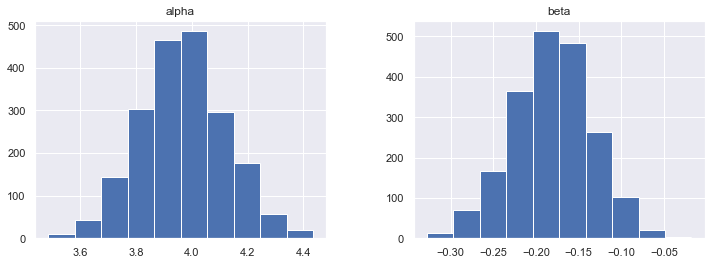

In [618]:
fig, ax = plt.subplots(figsize=(12, 4))
posterior_df[['alpha', 'beta']].hist(ax=ax);

## Part (B) 

Yes, this analysis does provide evidence that the rate of discovery is decreasing over time, because our posterior distribution of beta has a negative mean. The posterior 98% interval is:

In [647]:
lower, upper = posterior_df['beta'].quantile([0.01, 0.99])
t_lower, t_upper = np.exp(lower), np.exp(upper)
display(Math(f"$$Pr(e^{{ \\beta}} \in [{t_lower:.3f}, {t_upper:.3f}]) = 0.98$$"))

<IPython.core.display.Math object>

## Part (C)
Posterior distribution for the expected numebr of species discoveries in 2016 has the following 95% confidence interval:

In [70]:
from IPython.display import display, Math
lower, upper = posterior_df["lambda_2016"].quantile([0.025, 0.975])
display(Math(f"$$Pr(\lambda_{{2016}} \in [{lower:.3f}, {upper:.3f}]) = 0.95$$"))

<IPython.core.display.Math object>

## Part (D)
The 95% predicive interval for the number of species can be summarized as follows:

In [82]:
lower_y, upper_y = posterior_df["y_2016_tilde"].quantile([0.025, 0.975])
display(Math(f"$$Pr(\hat{{y}}_{{2016}} \in [{lower_y}, {upper_y}]) = 0.95$$"))

<IPython.core.display.Math object>

# Question 2

<AxesSubplot:ylabel='Count'>

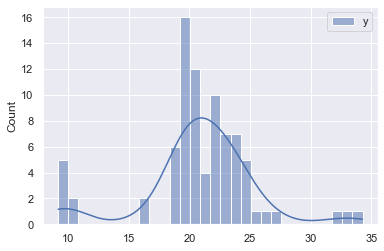

In [168]:
galaxies = pd.read_csv("galaxies.csv", index_col=0)
y = galaxies / 1000
y = y.rename(columns={'x': 'y'})
n = len(y)
sns.histplot(y, kde=True, bins=30)

In [447]:
galaxy_stan = """
data {
    int<lower=0> N;
    vector[N] y;
}
parameters {
    real mu;
    real sigma_2;
    real nu;
}
model {
    mu ~ normal(20, 100);
    sigma_2 ~ inv_gamma(.01, .01);
    nu ~ uniform(1, 30);
    y ~ student_t(nu, mu, sqrt(sigma_2));
}
generated quantities {
    real mean_post;
    real sd_post;
    vector[N] y_rep;
    for (i in 1:N)
        y_rep[i] = student_t_rng(nu, mu, sqrt(sigma_2));
    mean_post = mean(y_rep);
    sd_post = sd(y_rep);
}
"""

In [448]:
galaxy_model = pystan.StanModel(model_code=galaxy_stan)
galaxy_fit = galaxy_model.sampling(
    data=dict(y=y.y, N=n),
    iter=4000,
    chains=2)
galaxy_post = galaxy_fit.to_dataframe()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_67e4322dd75c78242c93d74ea3dfeb23 NOW.


## Part (A) Summarize Posteriors

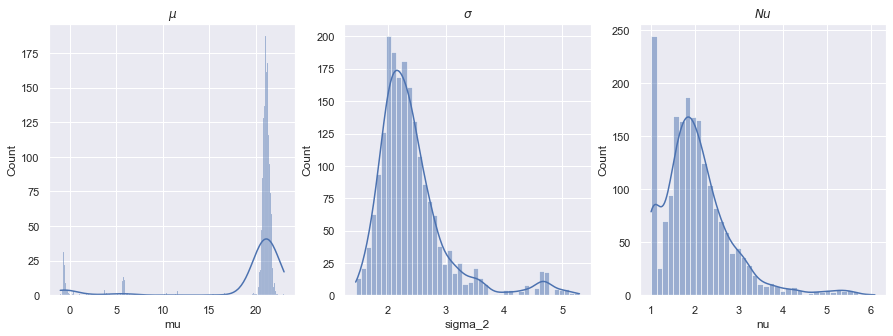

In [601]:
import matplotlib.pyplot as plt
sns.set()
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(galaxy_post['mu'], kde=True, ax=ax[0]).set_title("$\mu$")
sns.histplot(np.sqrt(galaxy_post['sigma_2']), kde=True, ax=ax[1]).set_title("$\sigma$")
sns.histplot(galaxy_post['nu'], kde=True, ax=ax[2]).set_title("$Nu$");

In [450]:
galaxy_post[['mu', 'sigma_2', 'nu']].quantile([.025, .25, .5, .75, .975]).T

0.025      0.250      0.500      0.750      0.975
mu      -0.750050  20.812415  21.087760  21.340890  21.777024
sigma_2  2.812026   4.171649   5.206089   6.730873  21.460948
nu       1.002641   1.545600   1.921582   2.366792   4.150107

## Part (B) Compare data to Posterior Dist

<AxesSubplot:ylabel='Count'>

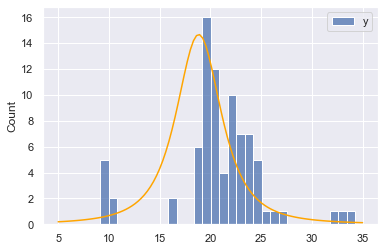

In [602]:
x = np.linspace(5, 35, 100)
p_x = stats.t(
    galaxy_post['nu'].mean(),
    loc=galaxy_post['mu'].mean(),
    scale=np.sqrt(galaxy_post['sigma_2']).mean()).pdf(x) * 100

fig, ax = plt.subplots()
sns.histplot(y, bins=30)
sns.lineplot(x=x, y=p_x, color='orange', ax=ax)

The model seems to weakly fit the data. It seems to have found the mean well, but a t distribution doesn't capture this data's distribution very well.

## Part (C) Posterior Predictive Checks

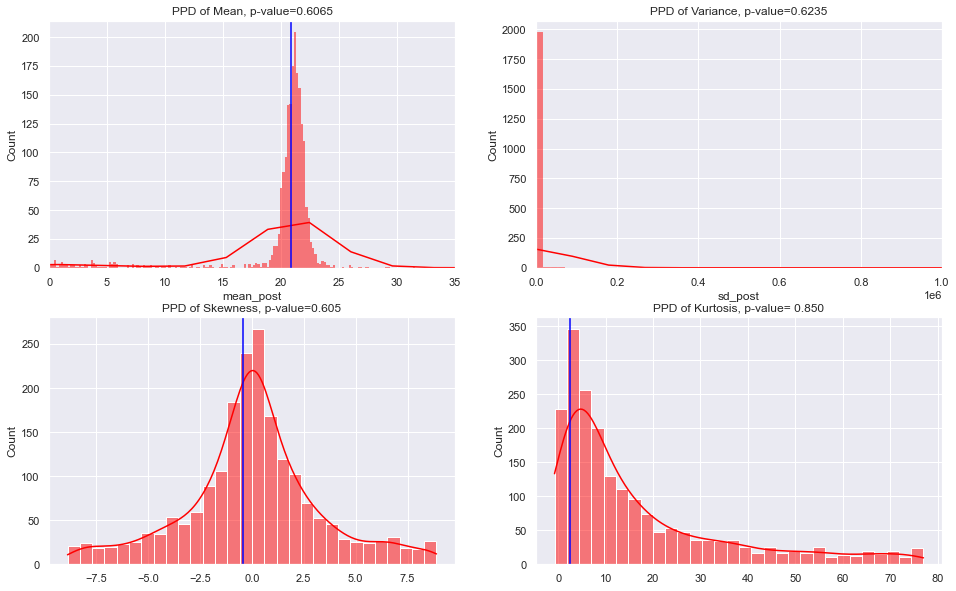

In [608]:
# PPC Mean
def ppc_mean(galaxy_post, y, ax):
    mean_p = (galaxy_post['mean_post'] > y.y.mean()).mean()
    sns.histplot(galaxy_post['mean_post'], kde=True, color='red', ax=ax)
    ax.axvline(x=y.y.mean(), ymin=0, ymax=1, color='blue')
    ax.set_title(f"PPD of Mean, p-value={mean_p}")
    ax.set_xlim(0, 35)


def ppc_var(galaxy_post, y, ax):
    var_post = galaxy_post['sd_post']**2
    var_p = (var_post > y.y.var()).mean()
    sns.histplot(var_post, kde=True, color='red', bins=1000, ax=ax)
    ax.axvline(x=y.y.var(), ymin=0, ymax=1, color='blue')
    ax.set_title(f"PPD of Variance, p-value={var_p}")
    ax.set_xlabel('var_post')
    ax.set_xlim(0, 1e6)

    
def ppc_skew(galaxy_post, y, ax):
    post_skew = galaxy_post[[col for col in galaxy_post.columns if "y_rep" in col]].apply(stats.skew, axis=1)
    skew_p = (post_skew > stats.skew(y.y)).mean()
    sns.histplot(post_skew, kde=True, bins=30, color='red', ax=ax)
    ax.axvline(x=stats.skew(y.y), ymin=0, ymax=1, color='blue')
    ax.set_title(f"PPD of Skewness, p-value={skew_p:.3f}");


def ppc_kurt(galaxy_post, y, ax):
    # Kurtosis
    post_kurt = galaxy_post[[col for col in galaxy_post.columns if "y_rep" in col]].apply(stats.kurtosis, axis=1)
    kurt_p = (post_kurt > stats.kurtosis(y.y)).mean()
    sns.histplot(post_kurt, kde=True, bins=30, ax=ax, color='red')
    ax.axvline(x=y.y.kurtosis(), ymin=0, ymax=1, color='blue')
    ax.set_title(f"PPD of Kurtosis, p-value={kurt_p: .3f}")


fig, axes = plt.subplots(2, 2, figsize=(16, 10))
ppc_mean(galaxy_post, y, axes[0, 0])
ppc_var(galaxy_post, y, axes[0, 1])
ppc_skew(galaxy_post, y, axes[1, 0])
ppc_kurt(galaxy_post, y, axes[1, 1])

The model seems to generate data that matches the empirical data in mean, variance, and skewness decently well based on p-values. However, it seems that variance of the posterior samples can take much larger values than the variance in the observed data which is probabaly not behavior we would like. Further, the distribution of kurtosis estimates from posterior samples takes on values greater than the sample kurtosis with a frequency of 85%, which is a bit high. This implies that our model will generate posterior predictive estimates with more kurtosis than we might want.

# Question 3

In [584]:
mixture_stan = """
data {
    int<lower=0> H; // number of mixtures
    int<lower=0> N;
    vector[N] y;
}
parameters {
    simplex[H] pi;
    ordered[H] mu;
    real<lower=0> sigma;
}

transformed parameters {
    real<lower=0> sigma_2;
    sigma_2 = sigma^2;
}

model {
    mu ~ normal(20, 100);
    sigma_2 ~ inv_gamma(0.01, 0.01);
    for(i in 1:N) {
        vector[H] lps = log(pi);
        for(h in 1:H)
            lps[h] += normal_lpdf(y[i] | mu[h], sigma);
        target += log_sum_exp(lps);
    }
}
"""

In [585]:
mixture_model = pystan.StanModel(model_code=mixture_stan)
mixture_model_fit = mixture_model.sampling(
    data=dict(y=y.y, N=n, H=3),
    iter=1000,
    chains=4)
mixture_model_post = mixture_model_fit.to_dataframe()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6644b6c81076acc77239dbff776b1446 NOW.


## Part (A) Summarize the Posteriors

In [586]:
mixture_model_fit

Inference for Stan model: anon_model_6644b6c81076acc77239dbff776b1446.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
pi[1]      0.1  7.9e-4   0.03   0.04   0.07   0.09   0.12   0.17   1714    1.0
pi[2]     0.85  1.0e-3   0.04   0.76   0.83   0.86   0.88   0.92   1617    1.0
pi[3]     0.05  5.5e-4   0.02   0.01   0.03   0.05   0.06   0.11   1989    1.0
mu[1]     9.79    0.03   0.85   8.19   9.22   9.78  10.34  11.46    829    1.0
mu[2]     21.4  5.1e-3   0.25   20.9  21.24   21.4  21.56  21.86   2338    1.0
mu[3]    32.72    0.03   1.32  30.03   31.8  32.77  33.63  35.17   1638    1.0
sigma     2.12  4.0e-3   0.17   1.81    2.0   2.11   2.23   2.47   1800    1.0
sigma_2    4.5    0.02   0.73   3.26    4.0   4.43   4.97   6.11   1794    1.0
lp__    -217.0    0.06   1.78 -221.3 -217.9 -216.7 -215.6 -214.5    969    1.0

Samples were drawn usi

## Part (B) 
Graphically compare mixture of Normals using posterior means with observed data

In [637]:
x = np.linspace(0, 40, 1000)
elements = [
    mixture_model_post[f'pi[{i}]'].mean() \
    * stats.norm(
        loc=mixture_model_post[f"mu[{i}]"].mean(),
        scale=mixture_model_post["sigma_2"].mean()).pdf(x)
    for i in range(1, 4)
]

In [638]:
dist = pd.DataFrame({
    "x": x,
    "mixture_1": elements[0],
    "mixture_2": elements[1],
    "mixture_3": elements[2],
})
dist= pd.melt(dist, id_vars='x', var_name='mixture', value_name='pdf')

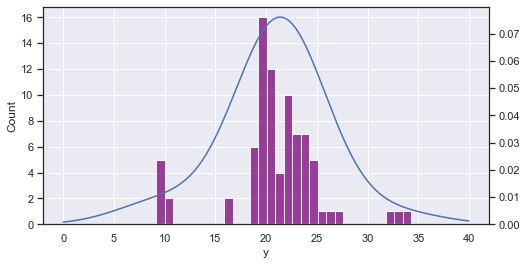

In [641]:
fig, ax = plt.subplots(figsize=(8, 4))

sns.set_style('ticks')
sns.histplot(y.y, bins=30, ax=ax, color='purple')
ax2 = ax.twinx()
#sns.lineplot(x='x', y='pdf', hue='mixture', data=dist, ax=ax2)
dist.groupby('x')['pdf'].sum().plot(ax=ax2)
ax2.set_ylim(0, ax2.get_ylim()[1]);

Based on this visualization, I believe this model fits the data much better as it accounts for the lower probability of events in spaces wher ethe data has gaps. THough I do think the second normal distribution has a higher sd than I would have anticipated.

## Part (C)

In [590]:
import random
from tqdm.notebook import tnrange

In [591]:
S = mixture_model_post.shape[0]
n = y.shape[0]
post_samples = np.zeros((S, n))
post_mean = np.zeros(S)

for s in tnrange(S):
    pi_s = [
        mixture_model_post.iloc[s]['pi[1]'],
        mixture_model_post.iloc[s]['pi[2]'],
        mixture_model_post.iloc[s]['pi[3]'],
    ]
    z = random.choices(range(1, 4), weights=pi_s, k=n)
    for i in range(n):
        post_samples[s, i] = stats.norm(
            loc=mixture_model_post.iloc[s][f'mu[{z[i]}]'],
            scale=np.sqrt(mixture_model_post.iloc[s]['sigma_2'])).rvs(1)[0]
    post_mean[s] = post_samples[s, ].mean()

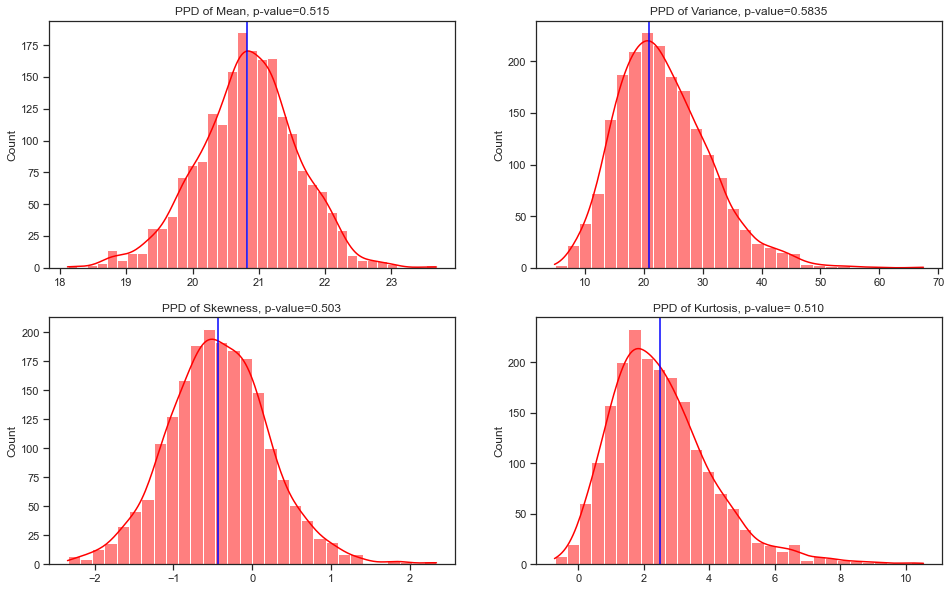

In [592]:
# PPC Mean
def ppc_mean(post_samples, y, ax):
    sample_means = post_samples.mean(axis=1)
    mean_p = (sample_means > y.y.mean()).mean()
    sns.histplot(sample_means, kde=True, color='red', ax=ax)
    ax.axvline(x=y.y.mean(), ymin=0, ymax=1, color='blue')
    ax.set_title(f"PPD of Mean, p-value={mean_p}")


def ppc_var(post_samples, y, ax):
    sample_var = post_samples.var(axis=1)
    var_p = (sample_var > y.y.var()).mean()
    sns.histplot(sample_var, kde=True, color='red', bins=30, ax=ax)
    ax.axvline(x=y.y.var(), ymin=0, ymax=1, color='blue')
    ax.set_title(f"PPD of Variance, p-value={var_p}")


def ppc_skew(post_samples, y, ax):
    post_skew = stats.skew(post_samples, axis=1)
    skew_p = (post_skew > stats.skew(y.y)).mean()
    sns.histplot(post_skew, kde=True, bins=30, color='red', ax=ax)
    ax.axvline(x=stats.skew(y.y), ymin=0, ymax=1, color='blue')
    ax.set_title(f"PPD of Skewness, p-value={skew_p:.3f}");


def ppc_kurt(post_samples, y, ax):
    # Kurtosis
    post_kurt = stats.kurtosis(post_samples, axis=1)
    kurt_p = (post_kurt > stats.kurtosis(y.y)).mean()
    sns.histplot(post_kurt, kde=True, bins=30, ax=ax, color='red')
    ax.axvline(x=y.y.kurtosis(), ymin=0, ymax=1, color='blue')
    ax.set_title(f"PPD of Kurtosis, p-value={kurt_p: .3f}")


fig, axes = plt.subplots(2, 2, figsize=(16, 10))
ppc_mean(post_samples, y, axes[0, 0])
ppc_var(post_samples, y, axes[0, 1])
ppc_skew(post_samples, y, axes[1, 0])
ppc_kurt(post_samples, y, axes[1, 1])


From the posterior checks, I can conclude that our model does seem to generate data with very similar first, second, third, and fourth moments as the input data. This gives us confidence that this mixture model was able to fit the data better. As noted in lecture, it does seem that mixtures of gaussians are truly quite a flexible model family.